In [1]:
import os
import torch
import random
import numpy as np
import pandas as pd
from torch import nn
from torch.utils import data
from matplotlib import pyplot as plt
from torch.nn import functional as F
from IPython.display import clear_output
from keras.preprocessing import text, sequence
from tqdm._tqdm_notebook import tqdm_notebook as tqdm

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  import sys
Using TensorFlow backend.


Code references: <br>many compenents from this code is taken from https://www.kaggle.com/bminixhofer/simple-lstm-pytorch-version
<br>preprocess modulue from https://www.kaggle.com/gpreda/jigsaw-fast-compact-solution

In [2]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [4]:
if os.path.exists('/kaggle/working/glove.6B.300d.txt')==False:
    !wget http://nlp.stanford.edu/data/glove.6B.zip;
    !unzip glove*.zip;
    !rm -r glove.6B.zip;

--2020-04-20 06:54:15--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-04-20 06:54:15--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-04-20 06:54:15--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [86]:
class Args():
    def __init__(self):
        self.glove_path = '/kaggle/working/glove.6B.300d.txt'
        self.train_df = '../input/tweet-sentiment-extraction/train.csv'
        self.test_df = '../input/tweet-sentiment-extraction/test.csv'
        self.lstm_hidden = 32
        self.linear = 64
        self.max_len = 220
        self.max_features = None
args = Args()

In [87]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')

def load_embeddings(path):
    with open(path) as f:
        return dict(get_coefs(*line.strip().split(' ')) for line in tqdm(f))

def build_matrix(word_index, path, dim=300):
    embedding_index = load_embeddings(path)
    embedding_matrix = np.zeros((len(word_index) + 1, dim))
    unknown_words = []
    
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_index[word]
        except KeyError:
            unknown_words.append(word)
    return embedding_matrix, unknown_words

In [88]:
def preprocess(data):
    punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
    def clean_special_chars(text, punct):
        for p in punct:
            text = text.replace(p, ' ')
        return text

    data = data.astype(str).apply(lambda x: clean_special_chars(x, punct))
    return data

In [89]:
def get_max_length(X):
    shapes = []
    for i in range(len(X)):
        shapes.append(len(X[i]))
    return max(shapes)

In [90]:
train = pd.read_csv(args.train_df)
test = pd.read_csv(args.test_df)

x_train = preprocess(train['text'])
y_train = np.where(train['sentiment'] == 'neutral', 0, np.where(train['sentiment'] == 'positive', 1, 2))
x_test = preprocess(test['text'])
y_test = np.where(test['sentiment'] == 'neutral', 0, np.where(test['sentiment'] == 'positive', 1, 2))

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(list(x_train) + list(x_test))

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)
print(get_max_length(x_train), get_max_length(x_test))
args.max_len = max(get_max_length(x_train), get_max_length(x_test))
x_train = sequence.pad_sequences(x_train, maxlen=args.max_len)
x_test = sequence.pad_sequences(x_test, maxlen=args.max_len)

35 32


In [91]:
args.max_features = args.max_features or len(tokenizer.word_index) + 1
args.max_features

27898

In [92]:
embedding_matrix, unknown_words_glove = build_matrix(tokenizer.word_index, args.glove_path)
print('n unknown words (glove): ', len(unknown_words_glove))


n unknown words (glove):  8280


In [93]:
embedding_matrix.shape

73092

In [94]:
x_train_torch = torch.tensor(x_train, dtype=torch.long).cuda()
y_train_torch = torch.tensor(y_train, dtype=torch.float32).cuda()
x_test_torch = torch.tensor(x_test, dtype=torch.long).cuda()
y_test_torch = torch.tensor(y_test, dtype=torch.float32).cuda()

In [95]:
class SpatialDropout(nn.Dropout2d):
    def forward(self, x):
        x = x.unsqueeze(2)   
        x = x.permute(0, 3, 2, 1)  
        x = super(SpatialDropout, self).forward(x)  
        x = x.permute(0, 3, 2, 1) 
        x = x.squeeze(2)  
        return x
    
class LSTM(nn.Module):
    def __init__(self, embedding_matrix, max_features=args.max_features, hidden=args.lstm_hidden, linear=args.linear):
        super(LSTM, self).__init__()
        embed_size = embedding_matrix.shape[1]
        
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.embedding_dropout = SpatialDropout(0.3)
        
        self.lstm = nn.LSTM(embed_size, hidden, bidirectional=False, batch_first=True)
        self.linear_out = nn.Linear(1120, 3)
        
    def forward(self, x):
        out = self.embedding(x)
        out = self.embedding_dropout(out) 
        out, _ = self.lstm(out)
        out = out.reshape(out.shape[0], out.shape[1]*out.shape[2])
        out = self.linear_out(out)
        return F.log_softmax(out)

In [102]:
def iterator(epoch, model, loader, criterion=nn.NLLLoss(), lr=0.01, scheduler=True, mode='train'):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    if scheduler:
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.6 ** epoch)
        scheduler.step()
    if mode == 'test':
        model.eval()
    elif mode == 'train':
        model.train()
    loss_ = 0
    correct_ = 0
    for data_ in tqdm(loader, disable=False):  
        data = data_[:-1]
        target = data_[-1].long()
        output = model(*data)
        loss = criterion(output, target)
        loss_ += loss.item()
        softmax_output = torch.exp(output)
        top_p, top_class = softmax_output.topk(1, dim=1)
        equals = top_class == target.view(*top_class.shape)
        correct_ += torch.mean(equals.type(torch.FloatTensor)).item()
        if mode=='train':
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return loss_/len(loader), correct_/len(loader)

In [103]:
def plot(metrics):
    clear_output()
    fig = plt.figure(figsize=(20,4))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    for key in metrics.keys():
        if key.endswith('loss'):
            ax1.plot(metrics[key], label=key[:-5])
            ax1.set_title(key[5:])
            ax1.legend()
        else:
            ax2.plot(metrics[key], label=key[:-9])
            ax2.set_title(key[5:])
            ax2.legend()
    plt.show()    

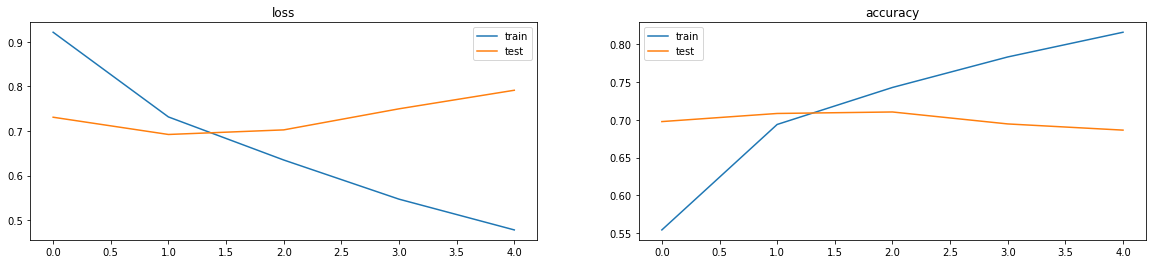

In [106]:
train_dataset = data.TensorDataset(x_train_torch, y_train_torch)
test_dataset = data.TensorDataset(x_test_torch, y_test_torch)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False)
metrics = {'train_loss':[],'train_accuracy':[], 'test_loss':[], 'test_accuracy':[]}
training_loss = []
training_accuracy = []
model = LSTM(embedding_matrix)
model.cuda()
criterion = nn.NLLLoss()
for i in range(5):
    seed_everything(0)
    loss_, acc_ = iterator(i, model, train_loader, criterion, lr=0.01, scheduler=False)
    metrics['train_loss'].append(loss_)
    metrics['train_accuracy'].append(acc_)
    loss_, acc_ = iterator(i, model, test_loader, scheduler=False, mode='test')
    metrics['test_loss'].append(loss_)
    metrics['test_accuracy'].append(acc_)
    plot(metrics) 